# 2019-02-10 - Custom spike sorting code
Problems : Images were artificially lenghtened, so each transition is not 1 frame but several, which causes a problem in defining what is a transition per se and what is actual sequence.

# Extracting data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import KwikTools as kt

In [2]:
dataset = kt.load('../190308_RAW/experiment1_100.raw.kwd',
                  'all')

In [3]:
dataset

{'info': {'0': <Attributes of HDF5 object at 140211766724128>},
 'data': {'0': <HDF5 dataset "data": shape (56801700, 43), type "<i2">},
 'channel_bit_volts': {'0': <HDF5 dataset "channel_bit_volts": shape (43,), type "<f4">},
 'timestamps': {'0': array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
         1.89338990e+03, 1.89338993e+03, 1.89338997e+03])}}

In [4]:
info = dataset['info']['0']
data = dataset['data']['0']
channels = dataset['channel_bit_volts']['0']
timestamps = dataset['timestamps']['0']

First, the timestamps :

In [5]:
print('Timestamps shape', timestamps.shape)
print('Timestamps range from %s to %s' % (timestamps.min(), timestamps.max()))
print('Which should be %s seconds' % (timestamps.max() - timestamps.min()))

Timestamps shape (56801700,)
Timestamps range from 0.0 to 1893.3899666666666
Which should be 1893.3899666666666 seconds


Then the channels :

In [6]:
channels.shape

(43,)

In [7]:
chans = 0
extras = 0
for chan in channels:
    if chan > .1:
        chans += 1
    else:
        extras += 1

In [8]:
print('There are %s recording channels and %s digital channels\
, one of which must be the photodiode' % (chans, extras))

There are 32 recording channels and 11 digital channels, one of which must be the photodiode


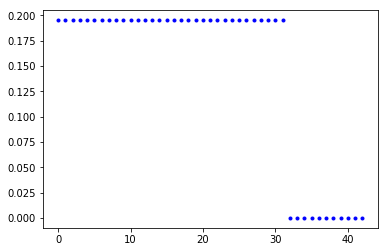

In [9]:
plt.plot(channels, '.b')

And now the actual data

In [10]:
data.shape

(56801700, 43)

In [11]:
data = np.asarray(data)
data = data.swapaxes(0, -1)

In [12]:
data.shape

(43, 56801700)

Text(0.5, 1.0, 'Unfiltered electrode signal')

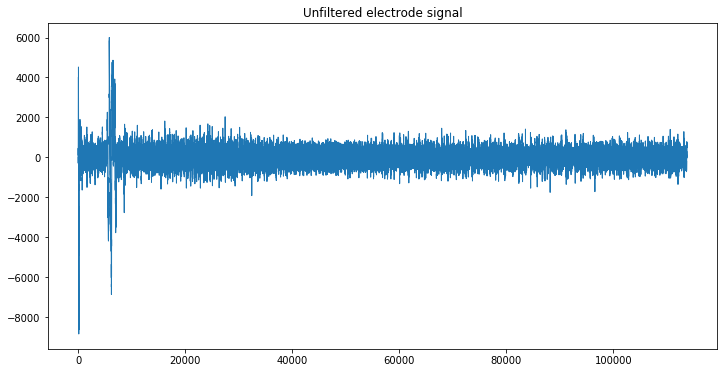

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(data[0][::100], linewidth=1)
plt.title("Unfiltered electrode signal")

Now to find the photodiode and the correct frames

In [18]:
%matplotlib notebook

<IPython.core.display.Javascript object>


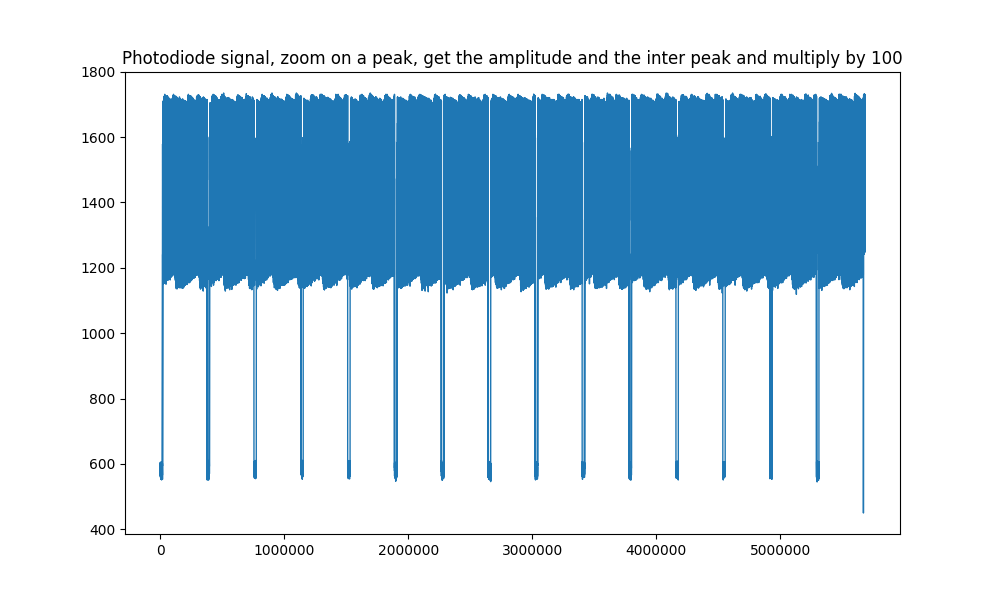

Text(0.5, 1.0, 'Photodiode signal, zoom on a peak, get the amplitude and the inter peak and multiply by 100')

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(data[35][::10], linewidth=1)
plt.title("Photodiode signal, zoom on a peak, get the amplitude and the inter peak and multiply by 100")

In [22]:
# https://stackoverflow.com/questions/15800895/finding-clusters-of-numbers-in-a-list
def grouper(iterable, timeframe):
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= timeframe:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group


above_threshold = np.where(data[35] > 1700)[0]
chunk_list = list(enumerate(grouper(above_threshold, 6000), 1))
print('Found %s chunks' % len(chunk_list))

Found 900 chunks


In [23]:
chunk_beg_list = []
for chunk in chunk_list :
    chunk_beg_list.append(chunk[1][0]/30000+timestamps.min())

Text(0.5, 1.0, 'Extracted photodiode sequences')

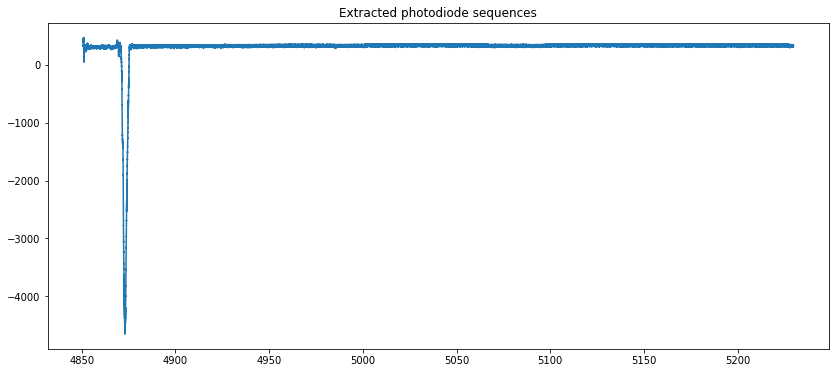

In [17]:
plt.figure(figsize=(14, 6))
plt.plot(timestamps[::10], data[1][::10])
for chunk in chunk_list:
    plt.plot(chunk[1][0]/30000+timestamps.min(), 1750, '.r', markersize=5)

plt.title('Extracted photodiode sequences')

# name changes
photodiode_data = data[35]
signal = photodiode_data
times = timestamps

# Define threshold based on signal mean
threshold = 1.1*photodiode_data.mean()

timeframe = 20

trues = (signal > threshold)

chunking_list = []
chunk_list = []
for it, a in enumerate(trues):
    if a == True:
        chunking_list.append(times[it])

chunking_list = np.asarray(chunking_list)

it = 10
for datapoint in chunking_list:
    try:
        it += 1
        if chunking_list[it]+1 < chunking_list[it+timeframe]:
            chunk_list.append(chunking_list[it-1])
            it += timeframe
            print('Found cluster at %s' % chunking_list[it])
    except IndexError:
        print('Done chunking')
        break

print('Found total of %s cluster(s)' % len(chunk_list))

In [18]:
block_to_see = 40

one_particular_presentation = chunk_beg_list[block_to_see+1] - \
    chunk_beg_list[block_to_see]
print('Visualizing signal from %ss to %ss, lasting %ss' % (chunk_beg_list[block_to_see+1],
                                                           chunk_beg_list[block_to_see],
                                                           one_particular_presentation))

time_beg = int((chunk_beg_list[block_to_see] - timestamps.min()) * 30000)
time_end = int((chunk_beg_list[block_to_see+1] - timestamps.min()) * 30000)
print('Array wise, the points range from %s to %s in the data' %
      (time_beg, time_end))

plt.figure(figsize=(12, 6))
plt.plot(timestamps[time_beg:time_end], data[0][time_beg:time_end])
plt.title('Raw signal for sequence n° %s' % block_to_see)
plt.tight_layout()

IndexError: list index out of range

# Filtering

In [19]:
from scipy.signal import butter, lfilter


def filter_data(data, low, high, sf, order=2):
    # Determine Nyquist frequency
    nyq = sf/2

    # Set bands
    low = low/nyq
    high = high/nyq

    # Calculate coefficients
    b, a = butter(order, [low, high], btype='band')

    # Filter signal
    filtered_data = lfilter(b, a, data)

    return filtered_data

In [20]:
filtered_data = filter_data(data[0], low=300, high=6000, sf=30000)

Text(0.5, 1.0, 'Filtered signal between 300 - 6000 Hz')

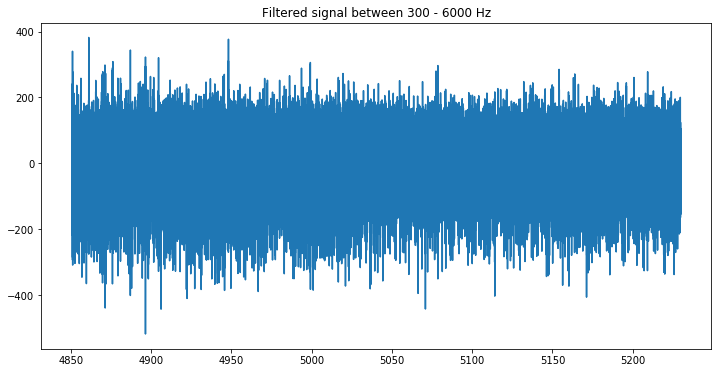

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(timestamps[::10], filtered_data[::10])
plt.title('Filtered signal between 300 - 6000 Hz')

In [22]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    '''
    Filtered data
    Number of points that will be extracted from signal
    Threshold factor, multiplied from signal mean
    Offset from the center for plotting afterwards
    Upper threshold, which eliminates artifacts
    '''
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) * tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp, spike_times = [], []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]

            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) + i

                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp -
                                    (spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(
                    wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)
                spike_times = np.append(spike_times, i)

    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]
    spike_times = spike_times[ind]

    return spike_samp, wave_form, spike_times

Found NAN/inf/aberrant values at 420
Found NAN/inf/aberrant values at 421


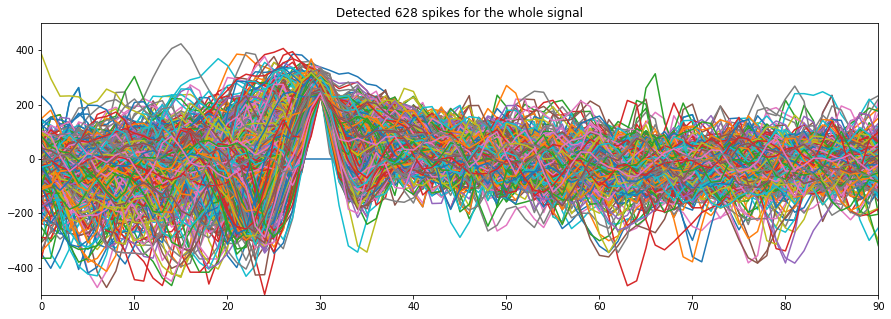

In [23]:
spike_samp, wave_form, spike_times = get_spikes(filtered_data, spike_window=50,
                                                tf=6.5, offset=20, max_thresh=340)

del_index = []
for it, waves in enumerate(wave_form):
    if np.NAN in waves or np.inf in waves or np.any(waves > 500) or np.any(waves< -500):
        print('Found NAN/inf/aberrant values at %s' % it)
        del_index.append(it)

wave_form = np.delete(wave_form, del_index, 0)
spike_times = np.delete(spike_times, del_index, 0)
spike_samp = np.delete(spike_samp, del_index, 0)

plt.figure(figsize=(15, 5))

for i in range(wave_form.shape[0]):
    plt.plot(wave_form[i, :])

plt.xlim([0, 90])
plt.ylim(-500, 500)
plt.title('Detected %s spikes for the whole signal' % wave_form.shape[0])
plt.show()

# PCA dimensionality reduction
Thank god there's a sklearn module for that

In [ ]:
import sklearn as sk
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
minmax = sk.preprocessing.MinMaxScaler()
scaled_data = minmax.fit_transform(wave_form)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(scaled_data)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2])
ax.view_init(30, 45)

plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.title(y=1.1, label='First three PC')

# Clustering *à la* K-means
TODO : Kohonen self-organizing maps ? peterwittek.com/somoclu-in-python.html

In [ ]:
from sklearn import cluster

# elbow method
sses = []
for k in range(1, 10):
    kmeans = cluster.KMeans(n_clusters=k, init='k-means++',
                            n_init=100, max_iter=1000).fit(pca_result)
    sses.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(sses)
plt.xlabel('Clusters number')
plt.ylabel('Inertia')
plt.title('Optimal Cluster search')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

n_clusters = 2
kmeans = cluster.KMeans(n_clusters=n_clusters, init='k-means++',
                        n_init=100, max_iter=1000).fit(pca_result)

axs[0].scatter(pca_result[:, 0], pca_result[:, 1],
               c=kmeans.labels_)

axs[0].set_xlabel('PC1', fontsize=18)
axs[0].set_ylabel('PC2', fontsize=18)
axs[0].set_title('Clustered PCAs')

for clust in range(n_clusters):
    cluster_mean = wave_form[kmeans.labels_ == clust].mean(axis=0)
    cluster_std = wave_form[kmeans.labels_ == clust].std(axis=0)

    axs[1].plot(cluster_mean, label='Cluster %s' % clust)
    axs[1].fill_between(np.linspace(0, cluster_mean.shape[0], cluster_mean.shape[0]),
                        cluster_mean-cluster_std, cluster_mean+cluster_std,
                        alpha=.2)
axs[1].set_title('Average waveforms')
axs[1].legend()

# Linking firing rate to sequences

In [ ]:
# from sample dots to actual time points, as a way to align spike_times and chunk_list
spike_times = (spike_times/30000)+timestamps.min()

In [ ]:
%matplotlib notebook

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(timestamps[::10], data[1][::10])
for chunk in chunk_beg_list:
    plt.plot(chunk, 1750, '.r', markersize=5)

plt.title('Doublecheck that there is no parasite initialisation sequence')

In [ ]:
%matplotlib inline

In [ ]:
del chunk_beg_list[0]

In [ ]:
spike_chunks = []
for it, chunk in enumerate(chunk_beg_list):
    spike_temp = []
    for spike in spike_times:
        if it+1 != len(chunk_beg_list) and spike < chunk_beg_list[it+1] and spike > chunk_beg_list[it]:
            print('Spike is in sequence no. %s' % it)
            spike_temp.append(spike)
    spike_chunks.append((spike_temp, it))

In [ ]:
plt.figure(figsize=(15, 8))
for sequence in spike_chunks:
    plt.scatter(sequence[0], np.ones_like(sequence[0]), c='red', s=5)

plt.plot(timestamps[::100], data[1][::100]-1750)
plt.title('Spikes (red) aligned with photodiode data')

In [ ]:
spike_length = []
for seq in spike_chunks:
    spike_length.append(len(seq[0]))

plt.figure(figsize=(12, 6))
plt.plot(spike_length)
plt.title('Spikes per sequence')

In [ ]:
fr_list = []
for i, chunk in enumerate(chunk_beg_list):
    try :
        curr_len = chunk_beg_list[i+1] - chunk_beg_list[i]
        fr_list.append(spike_length[i]/curr_len)
    except IndexError :
        print('Out of range')

plt.figure(figsize=(12, 6))
plt.plot(fr_list)
plt.title('Firing rate per sequence')

# Linking the results with the stimulation

In [24]:
import csv

thetas_list = []
with open('./sequences/MC_psychopy_var_2019-03-08_13:30:50/sequence.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        thetas_list.append((int(row[0]), float(row[1]), float(row[2])))

In [28]:
del thetas_list[-1]
del chunk_beg_list[-1]

In [29]:
len(chunk_beg_list)

899

In [30]:
len(thetas_list)

899

In [27]:
len(fr_list)

NameError: name 'fr_list' is not defined

[(0, 0.0, 0.09817477042468103),
 (1, 0.28559933214452665, 0.09817477042468103),
 (2, 1.9991953250116865, 0.19634954084936207),
 (3, 2.5703939893007397, 0.09817477042468103),
 (4, 0.5711986642890533, 0.7853981633974483),
 (5, 2.8559933214452666, 1.5707963267948966),
 (6, 1.7135959928671598, 0.7853981633974483),
 (7, 2.5703939893007397, 0.7853981633974483),
 (8, 0.5711986642890533, 0.39269908169872414),
 (9, 3.141592653589793, 0.39269908169872414),
 (10, 2.5703939893007397, 0.19634954084936207),
 (11, 2.8559933214452666, 0.09817477042468103),
 (12, 1.7135959928671598, 0.19634954084936207),
 (13, 0.0, 0.7853981633974483),
 (14, 2.8559933214452666, 0.39269908169872414),
 (15, 0.8567979964335799, 0.39269908169872414),
 (16, 0.28559933214452665, 0.7853981633974483),
 (17, 0.28559933214452665, 0.19634954084936207),
 (18, 2.284794657156213, 0.09817477042468103),
 (19, 0.0, 1.5707963267948966),
 (20, 2.284794657156213, 0.7853981633974483),
 (21, 0.8567979964335799, 1.5707963267948966),
 (22, 1.

In [ ]:
polar_plot_list = [] 
for sequence in thetas_list :
        print('At sequence %s, FR is %s' % (sequence[0], fr_list[sequence[0]]))
        print('Theta is %s, B_theta is %s' % (sequence[1] * 180 / np.pi, sequence[2] * 180 / np.pi))
        polar_plot_list.append((sequence[1], fr_list[sequence[0]]))

In [ ]:
#sorting by theta
sorted_by_theta = sorted(polar_plot_list, key=lambda tup: tup[0])
sorted_by_theta = np.asarray(sorted_by_theta)

#summing along thetas
theta_set = {x[0] for x in sorted_by_theta}
theta_sums = [(i,sum(x[1]for x in sorted_by_theta if x[0] == i)) for i in theta_set]
theta_sums = sorted(theta_sums, key=lambda tup: tup[0])

# late day wacky variable separation
angles, frs = [], []
for sums in theta_sums :
    angles.append(sums[0])
    frs.append(sums[1])

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = plt.subplot(111, projection='polar')
ax.plot(angles, np.asarray(frs)/15)

ax.grid(True)

ax.set_title("Orientation preference", va='bottom')
plt.show()